## Inteligencia Artificial
## - Laboratorio 5 -
Autores:
- Mark Albrand 
- Jimena Hernández

### Task 1 - Graph-Search

In [141]:
import matplotlib.pylab as plt
import numpy as np

### Task 1.1 - Discretización de la imagen

In [142]:
from PIL import Image
import numpy as np
def convertir_a_discreto(imagen_path, tamano_bloque):
    # Cargar la imagen
    imagen = Image.open(imagen_path)
    imagen_np = np.array(imagen)
    
    # Dimensiones de la imagen
    alto, ancho, _ = imagen_np.shape
    
    nuevo_alto = (alto // tamano_bloque) + 1
    nuevo_ancho = (ancho // tamano_bloque) + 1

    print(f'Alto: {alto}, Ancho: {ancho}')
    print(f'Nuevo alto: {nuevo_alto}, Nuevo ancho: {nuevo_ancho}')

    # Redimensionar la imagen
    imagen_salida = np.zeros((nuevo_alto, nuevo_ancho, 3), dtype=np.uint8)
    
    for y in range(0, alto, tamano_bloque):
        for x in range(0, ancho, tamano_bloque):
            new_y = y // tamano_bloque
            new_x = x // tamano_bloque
            # Extraer el bloque
            bloque = imagen_np[y:y+tamano_bloque, x:x+tamano_bloque]
            
            # Calcular el color promedio del bloque
            color_promedio = bloque.mean(axis=(0,1)).astype(int)
            #convertir los colores difuminados al color mas predominante
            #verde
            if color_promedio[1] > color_promedio[0] and color_promedio[1] > color_promedio[2]:
                color_promedio[1] = 255
                color_promedio[0] = 0
                color_promedio[2] = 0 
            #rojo
            elif color_promedio[0] > color_promedio[1] and color_promedio[0] > color_promedio[2]:
                color_promedio[0] = 255
                color_promedio[1] = 0
                color_promedio[2] = 0

            #grises
            elif color_promedio[0] == color_promedio[1] and color_promedio[0] == color_promedio[2] and color_promedio[0]< 255:
                color_promedio[0] = 0
                color_promedio[1] = 0
                color_promedio[2] = 0

            else:
                color_promedio[0] = 255
                color_promedio[1] = 255
                color_promedio[2] = 255
            
            # Asignar el color promedio al bloque correspondiente en la imagen de salida
            imagen_salida[new_y, new_x] = color_promedio
    
    imagen_discreta = Image.fromarray(imagen_salida)
    return imagen_discreta

Las áreas blancas representan caminos libres
Las áreas negras representan paredes sobre las cuales no se puede pasar
Las áreas verdes representan la meta (goalTest positivos) (pueden ser varios)
La área roja representa el punto de inicio (solo podrá haber uno)

### Task 1.2 - Framework de Problemas

Puede entenderse como un framework con los siguientes
elementos
- ○ Estado inicial (s_start) CHEQUE
- ○ Función de acción actions(s) → {a 1, a 2,...,a n} CHEQUE
- ○ Función de costo de paso cost(s,a,s’) → R CHEQUE
-    Estado actual, acción y estado siguiente -> Cuánto cuesta hacer el moviemiento
- ○ Función de resultados results(s,a) → s’
-    Se usa después de actions, dice a que estado se llega usando lo que dio actions
- ○ Función de goalTest(s) → {True, False}
    Se pasa de cada config nueva (estado actual), si es la meta o no

● Además, algunas veces es útil agregar
- ○ Función de costo de ruta pathCost(s 1, s 2,...,s n) → R
■ s i = results(s i-1,a i )

In [241]:
from typing import TypedDict

class legend_dict(TypedDict):
    """
    Define el tipo de dato para el diccionario de leyenda
    Los numpy arrays son de 3 elementos, representando los colores RGB
    """
    wall: np.array
    path: np.array
    start: np.array
    end: np.array


class SolveMaze:
    maze: np.array
    starting_point: tuple[int, int]  # (y, x)
    goal: list[tuple[int, int]] = []  # Lista de puntos finales

    legend: legend_dict = {
        "wall": np.array([0, 0, 0]),  # black
        "path": np.array([255, 255, 255]),  # white
        "start": np.array([255, 0, 0]),  # red
        "end": np.array([0, 255, 0])  # green
    }

    def __init__(self, maze: np.array):
        if maze.ndim != 3:
            raise ValueError("Maze debe ser un arreglo tridimensional")

        self.maze = maze
        self.starting_point = self._findStartinPoint()
        self.goal = self._findEndPoints()

    
    def _findStartinPoint(self) -> tuple[int, int]:
        width, height, _ = self.maze.shape
        sp = None
        acts = -1
        for y in range(0, height-1):
            for x in range(0, width-1):
                if np.array_equal(self.maze[y, x], self.legend["start"]):  # Buscar el punto de inicio, definido por el color en legend
                    act = self.actions((y, x))

                    if len(act) > acts:
                        sp = (y, x)
                        acts = len(act)
        return sp
    
    def _findEndPoints(self) -> list[tuple[int, int]]:
        width, height, _ = self.maze.shape
        end_points = []
        for y in range(0, height-1):
            for x in range(0, width-1):
                if np.array_equal(self.maze[y, x], self.legend["end"]):  # Buscar el punto final, definido por el color en legend
                    end_points.append((y, x))

        if len(end_points) == 0:
            raise ValueError("No hay punto final en el laberinto")
        
        return end_points
    
    def __str__(self) -> str:
        return f"SolveMaze(maze={self.maze.shape}, starting_point={self.starting_point})"
    
    def actions(self, current_pos: tuple[int, int]) -> list[tuple[int, int]]:
        """
        Dada una posición, regresa las posiciones a las que se puede mover
        """
        y, x = current_pos
        possible_actions = []
        height, width, _ = self.maze.shape
        # Regresar las posiciones a las que se puede mover: Path
        if y > 0 and np.array_equal(self.maze[y-1, x], self.legend["path"]):
            # Si no estamos en el borde superior y la celda de arriba es un camino
            # Arriba
            possible_actions.append((y-1, x))
        if y < height-1 and np.array_equal(self.maze[y+1, x], self.legend["path"]):
            # Si no estamos en el borde inferior y la celda de abajo es un camino
            # Abajo
            possible_actions.append((y+1, x))
        if x > 0 and np.array_equal(self.maze[y, x-1], self.legend["path"]):
            # Si no estamos en el borde izquierdo y la celda de la izquierda es un camino
            # Izquierda
            possible_actions.append((y, x-1))
        if x < width-1 and np.array_equal(self.maze[y, x+1], self.legend["path"]):
            # Si no estamos en el borde derecho y la celda de la derecha es un camino
            # Derecha
            possible_actions.append((y, x+1))

        # Regresar las posiciones a las que se puede mover: End
        if y > 0 and np.array_equal(self.maze[y-1, x], self.legend["end"]):
            # Si no estamos en el borde superior y la celda de arriba es el punto final
            # Arriba
            possible_actions.append((y-1, x))
        if y < height-1 and np.array_equal(self.maze[y+1, x], self.legend["end"]):
            # Si no estamos en el borde inferior y la celda de abajo es el punto final
            # Abajo
            possible_actions.append((y+1, x))
        if x > 0 and np.array_equal(self.maze[y, x-1], self.legend["end"]):
            # Si no estamos en el borde izquierdo y la celda de la izquierda es el punto final
            # Izquierda
            possible_actions.append((y, x-1))
        if x < width-1 and np.array_equal(self.maze[y, x+1], self.legend["end"]):
            # Si no estamos en el borde derecho y la celda de la derecha es el punto final
            # Derecha
            possible_actions.append((y, x+1))
        
        return possible_actions
    
    def cost(self, next_pos: tuple[int, int]) -> int:
        """
        Dada una posición y una acción, regresa el costo de llegar a esa posición
        """
        actions_next = self.actions(next_pos)
        costo = 1

        # Cantidad de acciones posibles
        match len(actions_next):
            case 0:
                costo += 9999
            case 1:
                costo += 3
            case 2:
                costo += 2
            case 3:
                costo += 1
            case 4:
                pass
            case _:
                pass

        
        # De las acciones posibles, si una es el punto final, reducir el costo
        for action in actions_next:
            if np.array_equal(action, legend_dict["end"]):
                costo -= 15
                break

        return costo
    
    def heuristic_manhattan(self, current_pos: tuple[int, int]) -> int:
        """
        Dada una posición, regresa la heurística de llegar a esa posición
        """
        return abs(current_pos[0] - self.goal[0][0]) + abs(current_pos[1] - self.goal[0][1])
    
    def heuristic_euclidean(self, current_pos: tuple[int, int]) -> int:
        """
        Dada una posición, regresa la heurística de llegar a esa posición
        """
        return np.sqrt((current_pos[0] - self.goal[0][0])**2 + (current_pos[1] - self.goal[0][1])**2)
        

    def goalTest(self, current_pos: tuple[int, int]) -> bool:
        """
        Dada una posición, regresa si es el punto final
        """
        return np.array_equal(self.maze[current_pos], self.legend["end"])
    
    def pathCost(self, path: list[tuple[int, int]]) -> int:
        """
        Dado un camino, regresa el costo total de recorrerlo
        """
        costo = 0
        for pos in path:
            costo += self.cost(pos)
        return costo


### BFS
Este algoritmo trabaja, empezando por visitar la posición inicial y agregando sus actions a una cola para posteriormente sacar de la cola cada uno y visitar dichos actions.

In [176]:
from collections import deque

def breadthFirstSearch(problem: SolveMaze) -> list[tuple[int, int]]:
    """
    Realiza una búsqueda en amplitud para encontrar el camino más corto
    """
    start = problem.starting_point
    if problem.goalTest(start):
        return start
    frontier = deque([(start, [start])])
    explored = set()
    while frontier:
        current_pos, path = frontier.popleft()  # Cola
        
        if problem.goalTest(current_pos):
            return path
        
        if current_pos in explored:
            continue
        
        explored.add(current_pos)
        
        for action in problem.actions(current_pos):
            if action not in explored and action not in frontier:
                frontier.append((action, path + [action]))
    return None

In [177]:
def drawPath(maze: np.array, path: list[tuple[int, int]]) -> np.array:
    """
    Dado un laberinto y un camino, dibuja el camino en el laberinto
    """
    maze_with_path = maze.copy()
    for pos in path:
        y, x = pos
        maze_with_path[y, x] = np.array([0, 0, 255])  # blue
    return maze_with_path

### DFS 
Este algoritmo empieza visitando la posición inicial, para dicha posición se colocan los actions de esta en un stack, cada uno de estos actions es visitado junto con sus actions respectivas.

In [178]:
from collections import deque as queue

def depth_first_search(maze: SolveMaze) -> list[tuple[int, int]]:
    visited = set()
    stack = queue([(maze.starting_point, [maze.starting_point])]) #empezamos en el punto de inicio

    if maze.goalTest(maze.starting_point):
        return maze.starting_point
    
    while stack:
        # agarrar el primer elemento de la pila
        current, path = stack.pop()  # Queue

        if maze.goalTest(current):
            return path
        
        if current in visited:
            continue

        visited.add(current)
        for action in maze.actions(current): #obtenemos las acciones posibles
            stack.append((action, path + [action])) #agregamos las acciones a la pila
    return None 

### A*
Utiliza una heurística para estimar la distancia al objetivo, y realiza una búsqueda eficiente utilizando conjuntos y diccionarios para llevar un seguimiento de los nodos visitados, los costos acumulativos y los puntajes heurísticos. 

#### Heurísticas
Decidimos utilizar heurísticas de aproximación debido a que conlleva menos tiempo de ejecución. 
Por las que optamos fueron: 
- La distancia Manhattan, que es la suma de los valores absolutos entre el goal y el punto actual 
- La distancia euclediana, que es la raiz de la suma de los cuadros de la distancia entre los componentes del punto actual y el de meta.

In [238]:
import numpy as np
from typing import List

def a_star(maze_solver: SolveMaze, h: callable):
    start = maze_solver.starting_point
    goal = maze_solver.goal[0]  # Tomamos solo el primer punto final, podrían ser múltiples

    # Inicializamos el conjunto abierto con el nodo inicial
    openSet = {start}

    # Inicializamos los diccionarios para llevar registro de los puntajes g y f
    cameFrom = {}  # Diccionario para reconstruir el camino
    gScore = {start: 0}  # Puntaje g de llegar a la celda actual. Se refiere al costo de llegar a la celda actual
    fScore = {start: h(start)}  # Puntaje f de llegar a la celda actual. Se refiere al costo total de llegar a la celda actual

    while openSet:
        # Encontrar el nodo con el menor puntaje f en openSet
        current = min(openSet, key=lambda x: fScore.get(x, float('inf')))

        if current == goal:
            # Si hemos llegado al objetivo, reconstruir el camino y devolverlo
            return reconstruct_path(cameFrom, current)

        openSet.remove(current)

        for neighbor in maze_solver.actions(current):
            # Calculamos el puntaje tentativo g para el vecino
            tentative_gScore = gScore.get(current, float('inf')) + maze_solver.cost(neighbor)

            if tentative_gScore < gScore.get(neighbor, float('inf')):
                # Este camino es mejor que cualquier otro anterior. Registramos esto.
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h(neighbor)

                if neighbor not in openSet:
                    openSet.add(neighbor)

    # Si llegamos aquí, significa que no hay camino posible
    return "No se encontró un camino"

# Aquí reconstruimos el camino dada una estructura de datos cameFrom
def reconstruct_path(cameFrom, current):
    total_path = [current]
    while current in cameFrom:
        current = cameFrom[current]
        total_path.insert(0, current)
    return total_path

## Imagen 1

Alto: 582, Ancho: 582
Nuevo alto: 59, Nuevo ancho: 59


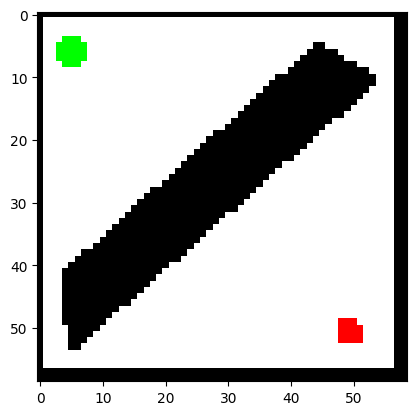

In [247]:
ruta_imagen = 'images/1.bmp' 
tamano_bloque = 10 #bloques de 14x14
imagen_discreta = convertir_a_discreto(ruta_imagen, tamano_bloque)
plt.imshow(imagen_discreta)
plt.show()

In [248]:
imagen_np = np.array(imagen_discreta)

In [249]:
maze = SolveMaze(imagen_np)
print(maze)
print(maze.actions(maze.starting_point))

SolveMaze(maze=(59, 59, 3), starting_point=(49, 48))
[(48, 48), (49, 47)]


### BFS

In [250]:
path_bfs = breadthFirstSearch(maze)

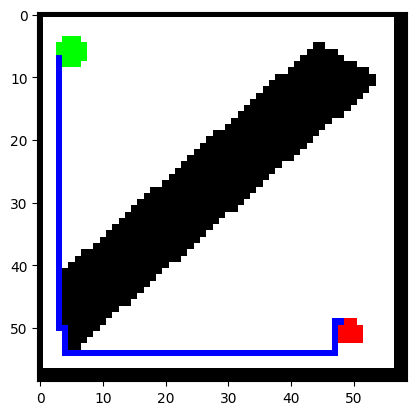

In [251]:
maze_with_path = drawPath(imagen_np, path_bfs)
plt.imshow(maze_with_path)
plt.show()

### DFS

In [252]:
path_dfs = depth_first_search(maze)
print(path_dfs)

[(49, 48), (49, 47), (49, 46), (49, 45), (49, 44), (49, 43), (49, 42), (49, 41), (49, 40), (49, 39), (49, 38), (49, 37), (49, 36), (49, 35), (49, 34), (49, 33), (49, 32), (49, 31), (49, 30), (49, 29), (49, 28), (49, 27), (49, 26), (49, 25), (49, 24), (49, 23), (49, 22), (49, 21), (49, 20), (49, 19), (49, 18), (49, 17), (49, 16), (49, 15), (49, 14), (49, 13), (49, 12), (49, 11), (50, 11), (50, 12), (50, 13), (50, 14), (50, 15), (50, 16), (50, 17), (50, 18), (50, 19), (50, 20), (50, 21), (50, 22), (50, 23), (50, 24), (50, 25), (50, 26), (50, 27), (50, 28), (50, 29), (50, 30), (50, 31), (50, 32), (50, 33), (50, 34), (50, 35), (50, 36), (50, 37), (50, 38), (50, 39), (50, 40), (50, 41), (50, 42), (50, 43), (50, 44), (50, 45), (50, 46), (50, 47), (51, 47), (51, 46), (51, 45), (51, 44), (51, 43), (51, 42), (51, 41), (51, 40), (51, 39), (51, 38), (51, 37), (51, 36), (51, 35), (51, 34), (51, 33), (51, 32), (51, 31), (51, 30), (51, 29), (51, 28), (51, 27), (51, 26), (51, 25), (51, 24), (51, 23),

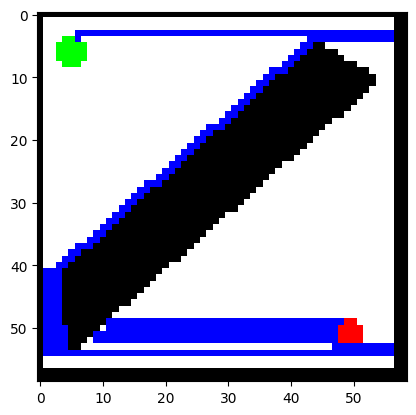

In [253]:
maze_with_path_dfs1 = drawPath(imagen_np, path_dfs)
plt.imshow(maze_with_path_dfs1)

### A*
#### Manhattan

In [254]:
path_a_star = a_star(maze, maze.heuristic_manhattan)
print(path_a_star)

[(49, 48), (49, 47), (49, 46), (49, 45), (49, 44), (49, 43), (49, 42), (49, 41), (49, 40), (49, 39), (49, 38), (49, 37), (49, 36), (49, 35), (49, 34), (49, 33), (49, 32), (49, 31), (49, 30), (49, 29), (49, 28), (49, 27), (49, 26), (49, 25), (49, 24), (49, 23), (49, 22), (49, 21), (49, 20), (49, 19), (49, 18), (49, 17), (49, 16), (49, 15), (49, 14), (49, 13), (49, 12), (50, 12), (50, 11), (51, 11), (51, 10), (52, 10), (52, 9), (53, 9), (53, 8), (54, 8), (54, 7), (54, 6), (54, 5), (54, 4), (54, 3), (53, 3), (52, 3), (51, 3), (50, 3), (50, 2), (49, 2), (48, 2), (47, 2), (46, 2), (45, 2), (44, 2), (43, 2), (42, 2), (41, 2), (40, 2), (39, 2), (38, 2), (37, 2), (36, 2), (35, 2), (34, 2), (33, 2), (32, 2), (31, 2), (30, 2), (29, 2), (29, 3), (28, 3), (28, 4), (27, 4), (26, 4), (25, 4), (24, 4), (23, 4), (22, 4), (21, 4), (20, 4), (19, 4), (18, 4), (17, 4), (16, 4), (15, 4), (14, 4), (13, 4), (12, 4), (11, 4), (10, 4), (9, 4), (8, 4), (7, 4), (6, 4), (5, 4), (4, 4)]


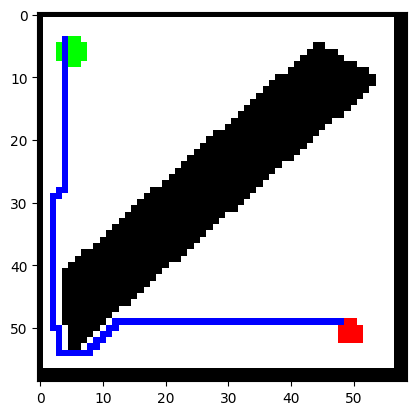

In [255]:
maze_with_path_a_star = drawPath(imagen_np, path_a_star)
plt.imshow(maze_with_path_a_star)
plt.show()

#### Euclidean

In [256]:
path_a_star_euclidean = a_star(maze, maze.heuristic_euclidean)
print(path_a_star_euclidean)

[(49, 48), (49, 47), (49, 46), (49, 45), (49, 44), (49, 43), (49, 42), (49, 41), (49, 40), (49, 39), (49, 38), (49, 37), (49, 36), (49, 35), (49, 34), (49, 33), (49, 32), (49, 31), (49, 30), (49, 29), (49, 28), (49, 27), (49, 26), (49, 25), (49, 24), (49, 23), (49, 22), (49, 21), (49, 20), (49, 19), (49, 18), (49, 17), (49, 16), (49, 15), (49, 14), (49, 13), (49, 12), (50, 12), (50, 11), (51, 11), (51, 10), (52, 10), (52, 9), (53, 9), (53, 8), (54, 8), (54, 7), (54, 6), (54, 5), (54, 4), (54, 3), (53, 3), (52, 3), (51, 3), (50, 3), (50, 2), (49, 2), (48, 2), (47, 2), (46, 2), (45, 2), (44, 2), (43, 2), (42, 2), (41, 2), (40, 2), (39, 2), (38, 2), (37, 2), (36, 2), (35, 2), (34, 2), (33, 2), (32, 2), (31, 2), (30, 2), (29, 2), (28, 2), (27, 2), (26, 2), (25, 2), (24, 2), (23, 2), (22, 2), (21, 2), (20, 2), (19, 2), (18, 2), (17, 2), (16, 2), (15, 2), (14, 2), (13, 2), (12, 2), (11, 2), (10, 2), (9, 2), (8, 2), (7, 2), (6, 2), (5, 2), (5, 3), (5, 4), (4, 4)]


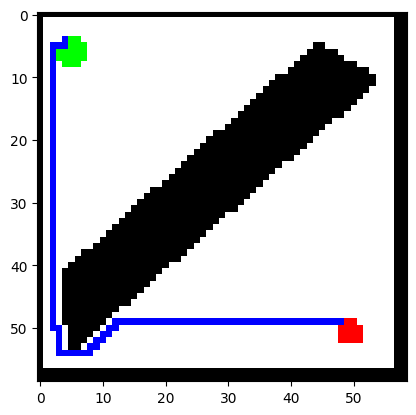

In [257]:
maze_with_path_a_star_euclidean = drawPath(imagen_np, path_a_star_euclidean)
plt.imshow(maze_with_path_a_star_euclidean)
plt.show()

## Imagen 3

Alto: 582, Ancho: 582
Nuevo alto: 59, Nuevo ancho: 59


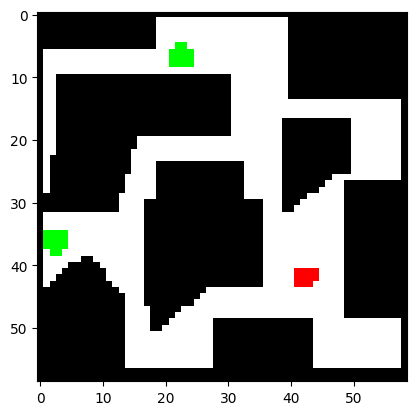

In [213]:
ruta_imagen3 = 'images/3.bmp'
tamano_bloque3 = 10
imagen_discreta3 = convertir_a_discreto(ruta_imagen3, tamano_bloque3)
plt.imshow(imagen_discreta3)
plt.show()

In [214]:
imagen_np3 = np.array(imagen_discreta3)
print(imagen_np3.shape)

(59, 59, 3)


In [215]:
maze3 = SolveMaze(imagen_np3)
print(maze3)

SolveMaze(maze=(59, 59, 3), starting_point=(41, 41))


### BFS

In [216]:
path_bfs3 = breadthFirstSearch(maze3)
print(path_bfs3)

[(41, 41), (40, 41), (39, 41), (38, 41), (37, 41), (36, 41), (35, 41), (34, 41), (33, 41), (32, 41), (32, 40), (32, 39), (32, 38), (31, 38), (30, 38), (29, 38), (28, 38), (27, 38), (26, 38), (25, 38), (24, 38), (23, 38), (22, 38), (21, 38), (20, 38), (19, 38), (18, 38), (17, 38), (16, 38), (15, 38), (14, 38), (13, 38), (12, 38), (11, 38), (10, 38), (9, 38), (8, 38), (8, 37), (8, 36), (8, 35), (8, 34), (8, 33), (8, 32), (8, 31), (8, 30), (8, 29), (8, 28), (8, 27), (8, 26), (8, 25), (8, 24)]


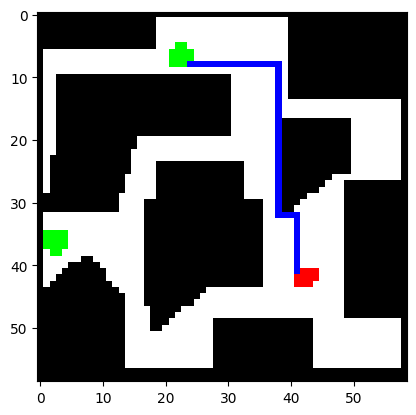

In [217]:
maze_with_path_bfs3 = drawPath(imagen_np3, path_bfs3)
maze_with_path_bfs3 = Image.fromarray(maze_with_path_bfs3)
plt.imshow(maze_with_path_bfs3)
plt.show()

### DFS

In [218]:
path_dfs3 = depth_first_search(maze3)
print(path_dfs3)


[(41, 41), (41, 40), (41, 39), (41, 38), (41, 37), (41, 36), (42, 36), (42, 37), (42, 38), (42, 39), (42, 40), (43, 40), (43, 39), (43, 38), (43, 37), (43, 36), (44, 36), (44, 37), (44, 38), (44, 39), (44, 40), (44, 41), (44, 42), (44, 43), (44, 44), (44, 45), (44, 46), (44, 47), (44, 48), (45, 48), (45, 47), (45, 46), (45, 45), (45, 44), (45, 43), (45, 42), (45, 41), (45, 40), (45, 39), (45, 38), (45, 37), (45, 36), (45, 35), (45, 34), (45, 33), (45, 32), (45, 31), (45, 30), (45, 29), (45, 28), (45, 27), (45, 26), (46, 26), (46, 27), (46, 28), (46, 29), (46, 30), (46, 31), (46, 32), (46, 33), (46, 34), (46, 35), (46, 36), (46, 37), (46, 38), (46, 39), (46, 40), (46, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (47, 47), (47, 46), (47, 45), (47, 44), (47, 43), (47, 42), (47, 41), (47, 40), (47, 39), (47, 38), (47, 37), (47, 36), (47, 35), (47, 34), (47, 33), (47, 32), (47, 31), (47, 30), (47, 29), (47, 28), (47, 27), (47, 26), (47, 25), (47, 24),

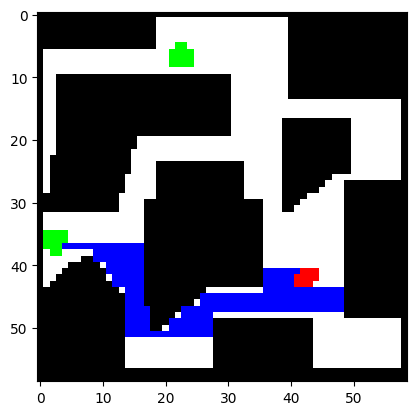

In [219]:
maze_with_path_dfs3 = drawPath(imagen_np3, path_dfs3)
maze_with_path_dfs3 = Image.fromarray(maze_with_path_dfs3)
plt.imshow(maze_with_path_dfs3)
plt.show()

### A*
#### Manhattan

In [220]:
path_a_star3 = a_star(maze3, maze3.heuristic_manhattan)
print(path_a_star3)

[(41, 41), (41, 40), (41, 39), (40, 39), (39, 39), (38, 39), (37, 39), (37, 38), (37, 37), (36, 37), (35, 37), (34, 37), (33, 37), (32, 37), (31, 37), (30, 37), (29, 37), (29, 36), (28, 36), (27, 36), (26, 36), (25, 36), (24, 36), (23, 36), (22, 36), (22, 35), (21, 35), (20, 35), (19, 35), (18, 35), (18, 34), (17, 34), (17, 33), (16, 33), (15, 33), (14, 33), (13, 33), (12, 33), (11, 33), (10, 33), (10, 32), (9, 32), (8, 32), (8, 31), (8, 30), (8, 29), (8, 28), (8, 27), (8, 26), (8, 25), (8, 24), (8, 23), (7, 23), (6, 23), (5, 23), (5, 22)]


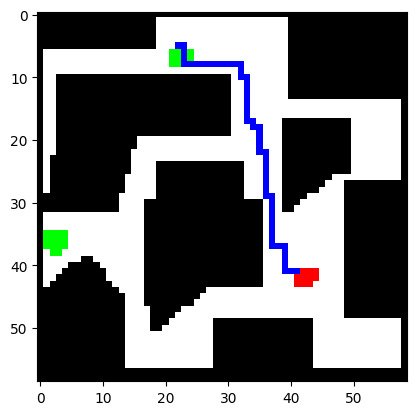

In [221]:
maze_with_path_a_star3 = drawPath(imagen_np3, path_a_star3)
maze_with_path_a_star3 = Image.fromarray(maze_with_path_a_star3)
plt.imshow(maze_with_path_a_star3)
plt.show()

#### Euclidean

In [231]:
path_a_star_euclidean3 = a_star(maze3, maze3.heuristic_euclidean)
print(path_a_star_euclidean3)

[(41, 41), (40, 41), (39, 41), (38, 41), (37, 41), (36, 41), (35, 41), (34, 41), (33, 41), (33, 40), (33, 39), (33, 38), (32, 38), (32, 37), (31, 37), (30, 37), (29, 37), (28, 37), (27, 37), (26, 37), (25, 37), (24, 37), (23, 37), (22, 37), (21, 37), (20, 37), (19, 37), (19, 36), (19, 35), (18, 35), (18, 34), (17, 34), (17, 33), (16, 33), (15, 33), (15, 32), (14, 32), (13, 32), (12, 32), (11, 32), (10, 32), (9, 32), (9, 31), (8, 31), (8, 30), (8, 29), (8, 28), (8, 27), (8, 26), (8, 25), (8, 24), (7, 24), (6, 24), (6, 23), (5, 23), (5, 22)]


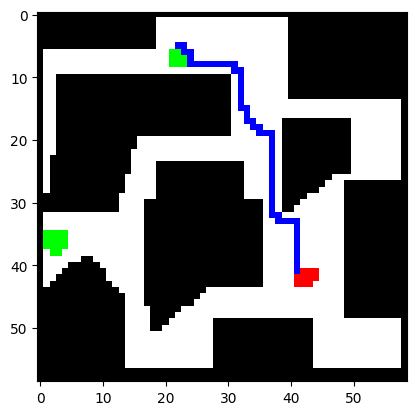

In [232]:
maze_with_path_a_star_euclidean3 = drawPath(imagen_np3, path_a_star_euclidean3)
maze_with_path_a_star_euclidean3 = Image.fromarray(maze_with_path_a_star_euclidean3)
plt.imshow(maze_with_path_a_star_euclidean3)
plt.show()

## Imagen 2

Alto: 582, Ancho: 582
Nuevo alto: 59, Nuevo ancho: 59


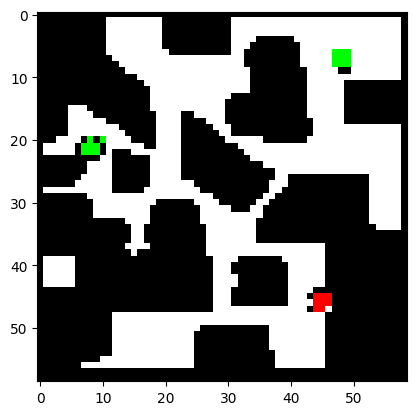

In [222]:
ruta_imagen2 = 'images/2.bmp'
tamano_bloque2 = 10
imagen_discreta2 = convertir_a_discreto(ruta_imagen2, tamano_bloque2)
plt.imshow(imagen_discreta2)
plt.show()

In [223]:
maze2 = SolveMaze(np.array(imagen_discreta2))


In [224]:
imagen_np2 = np.array(imagen_discreta2)

### BFS

In [225]:
path_dfs2 = breadthFirstSearch(maze2)
print(path_dfs2)

[(47, 45), (48, 45), (48, 44), (48, 43), (48, 42), (47, 42), (46, 42), (45, 42), (44, 42), (43, 42), (42, 42), (41, 42), (40, 42), (39, 42), (38, 42), (37, 42), (37, 41), (37, 40), (37, 39), (37, 38), (37, 37), (37, 36), (37, 35), (37, 34), (36, 34), (35, 34), (34, 34), (33, 34), (32, 34), (32, 33), (32, 32), (32, 31), (32, 30), (31, 30), (31, 29), (31, 28), (30, 28), (30, 27), (29, 27), (29, 26), (29, 25), (28, 25), (28, 24), (27, 24), (27, 23), (27, 22), (26, 22), (25, 22), (24, 22), (23, 22), (22, 22), (22, 21), (22, 20), (22, 19), (22, 18), (22, 17), (22, 16), (21, 16), (21, 15), (21, 14), (20, 14), (20, 13), (20, 12), (20, 11), (20, 10)]


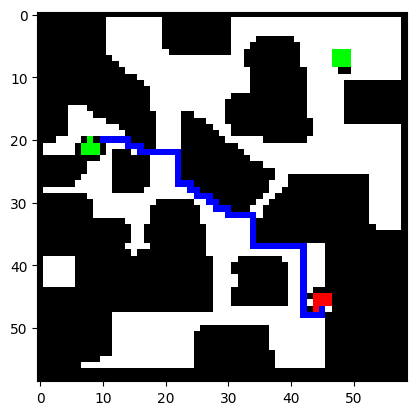

In [226]:
maze_with_path_dfs2 = drawPath(imagen_np2, path_dfs2)
maze_with_path_dfs2 = Image.fromarray(maze_with_path_dfs2)
plt.imshow(maze_with_path_dfs2)
plt.show()

### DFS

In [227]:
maze_with_path_dfs2 = depth_first_search(maze2)
print(maze_with_path_dfs2)

[(47, 45), (48, 45), (48, 44), (48, 43), (48, 42), (48, 41), (48, 40), (48, 39), (48, 38), (48, 37), (48, 36), (48, 35), (48, 34), (48, 33), (48, 32), (48, 31), (48, 30), (48, 29), (48, 28), (47, 28), (47, 29), (47, 30), (47, 31), (47, 32), (47, 33), (47, 34), (47, 35), (47, 36), (47, 37), (47, 38), (47, 39), (47, 40), (47, 41), (47, 42), (46, 42), (46, 41), (46, 40), (45, 40), (45, 41), (45, 42), (44, 42), (44, 43), (43, 43), (43, 44), (43, 45), (42, 45), (42, 44), (42, 43), (42, 42), (42, 41), (42, 40), (41, 40), (41, 41), (41, 42), (41, 43), (41, 44), (41, 45), (40, 45), (40, 44), (40, 43), (40, 42), (40, 41), (40, 40), (39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (39, 45), (38, 45), (38, 44), (38, 43), (38, 42), (38, 41), (38, 40), (38, 39), (38, 38), (38, 37), (38, 36), (38, 35), (38, 34), (38, 33), (38, 32), (38, 31), (38, 30), (38, 29), (38, 28), (38, 27), (37, 27), (37, 28), (37, 29), (37, 30), (37, 31), (37, 32), (37, 33), (37, 34), (36, 34), (36, 33), (36, 32), (36, 31),

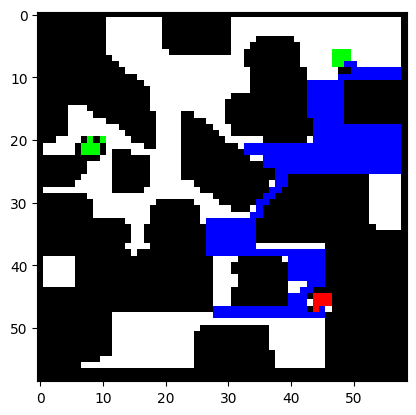

In [228]:
maze_with_path_dfs2 = drawPath(imagen_np2, maze_with_path_dfs2)
maze_with_path_dfs2 = Image.fromarray(maze_with_path_dfs2)
plt.imshow(maze_with_path_dfs2)
plt.show()

### A*
#### Manhattan

In [229]:
maze_with_path_a_star_2 = a_star(maze2, maze2.heuristic_manhattan)
print(maze_with_path_a_star_2)

[(47, 45), (48, 45), (48, 44), (48, 43), (48, 42), (48, 41), (47, 41), (46, 41), (45, 41), (44, 41), (43, 41), (42, 41), (41, 41), (40, 41), (39, 41), (38, 41), (38, 40), (38, 39), (37, 39), (37, 38), (37, 37), (37, 36), (37, 35), (37, 34), (37, 33), (36, 33), (35, 33), (34, 33), (33, 33), (33, 34), (32, 34), (31, 34), (31, 35), (30, 35), (30, 36), (29, 36), (29, 37), (28, 37), (27, 37), (27, 38), (26, 38), (25, 38), (25, 39), (24, 39), (23, 39), (23, 40), (23, 41), (23, 42), (23, 43), (22, 43), (21, 43), (21, 44), (21, 45), (21, 46), (20, 46), (19, 46), (18, 46), (17, 46), (16, 46), (15, 46), (14, 46), (13, 46), (12, 46), (11, 46), (10, 46), (9, 46), (8, 46), (7, 46), (6, 46), (6, 47)]


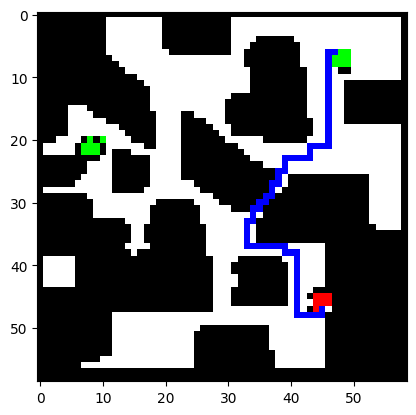

In [230]:
maze_with_path_a_star_2 = drawPath(imagen_np2, maze_with_path_a_star_2)
maze_with_path_a_star_2 = Image.fromarray(maze_with_path_a_star_2)
plt.imshow(maze_with_path_a_star_2)

#### Euclidean

In [233]:
maze_with_path_a_star_euclidean_2 = a_star(maze2, maze2.heuristic_euclidean)
print(maze_with_path_a_star_euclidean_2)

[(47, 45), (48, 45), (48, 44), (48, 43), (48, 42), (48, 41), (47, 41), (46, 41), (45, 41), (44, 41), (43, 41), (42, 41), (41, 41), (40, 41), (39, 41), (38, 41), (38, 40), (38, 39), (37, 39), (37, 38), (37, 37), (37, 36), (37, 35), (37, 34), (37, 33), (36, 33), (35, 33), (34, 33), (33, 33), (32, 33), (32, 34), (31, 34), (31, 35), (30, 35), (30, 36), (29, 36), (29, 37), (28, 37), (27, 37), (27, 38), (26, 38), (25, 38), (24, 38), (23, 38), (22, 38), (22, 39), (22, 40), (22, 41), (22, 42), (22, 43), (21, 43), (21, 44), (20, 44), (20, 45), (19, 45), (18, 45), (17, 45), (16, 45), (15, 45), (14, 45), (13, 45), (12, 45), (11, 45), (10, 45), (9, 45), (8, 45), (8, 46), (7, 46), (6, 46), (6, 47)]


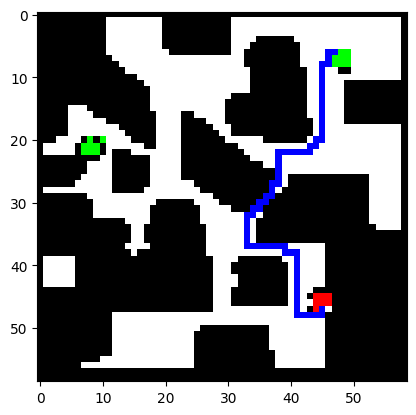

In [234]:
maze_with_path_a_star_euclidean_2 = drawPath(imagen_np2, maze_with_path_a_star_euclidean_2)
maze_with_path_a_star_euclidean_2 = Image.fromarray(maze_with_path_a_star_euclidean_2)
plt.imshow(maze_with_path_a_star_euclidean_2)
plt.show()